# CA2 Part 3: Depth from Stereo

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
import random as rm
import math
import cv2
import random
import gco

1221.2270770	0.0000000	479.5000000	
0.0000000	1221.2270770	269.5000000	
0.0000000	0.0000000	1.0000000	
1.0000000000	0.0000000000	0.0000000000	
0.0000000000	1.0000000000	0.0000000000	
0.0000000000	0.0000000000	1.0000000000	
0.0000000000	0.0000000000	0.0000000000	


1221.2270770	0.0000000	479.5000000	
0.0000000	1221.2270770	269.5000000	
0.0000000	0.0000000	1.0000000	
0.9998813487	0.0148994942	0.0039106989	
-0.0148907594	0.9998865876	-0.0022532664	
-0.0039438279	0.0021947658	0.9999898146	
-9.9909793759	0.2451742154	0.1650832670

In [2]:
def parameter():
    K1 = np.array([[1221.2270770,0,479.5],[0,1221.2270770,269.5],[0,0,1]])
    R1 = np.array([[1,0,0],[0,1,0],[0,0,1]])
    T1 = np.mat([0,0,0]).T
    K2 = np.array([[1221.2270770,0,479.5],[0,1221.227077,269.5],[0,0,1]])
    R2 = np.array([[0.9998813487,0.0148994942,0.0039106989],[-0.0148907594,0.9998865876,-0.0022532664],[-0.0039438279,0.0021947658,0.9999898146]])
    T2 = np.mat([-9.9909793759,0.2451742154,0.1650832670]).T
    invK1 = linalg.inv(K1) 
    return invK1,R1,T1,K2,R2,T2

### desparity function is used to pre-process the data to find a properiate dmax

In [3]:
def desparity(im1,threshold,precison = 0.0001,step = 10):
    [row,col,c] = im1.shape
    x = np.arange(0,col+step,step)
    y = np.arange(0,row+step,step)
    xx, yy = np.meshgrid(x, y)
    xx = xx.reshape(1,-1)
    yy = yy.reshape(1,-1)
    N_sample = len(xx[0])
    Xh = np.concatenate((xx,yy,np.ones([1,N_sample])),axis = 0)

    invK1,R1,T1,K2,R2,T2 = parameter()
    dmax = 10
    dmin = 0
    part1 = K2.dot(R2.T).dot(R1).dot(invK1).dot(Xh)
    while True:
        part2 = dmax * K2.dot(R2.T).dot(T1 - T2)
        Xh2 = part1 + part2
        Xh2 = Xh2[0:2,:] / Xh2[2,:]
        Xh2 = np.round(Xh2)
        count = 0
        for i in range(N_sample):
            p = Xh2[:,i]
            if p[0] < col and p[0] > -1 and p[1] < row and p[1] > -1:
                count += 1
                
        if count < threshold * N_sample :
            delta = dmax - dmin
            dmax = delta/2 + dmin
        else:
            delta = dmax - dmin
            dmin = dmax
            dmax = delta/2 + dmin
#         print(dmax,dmin,delta)
#         print(count)
        if delta < precison:
            break
        
    return dmax

In [4]:
# distance
def distance(xi,xj):
    return np.sum(np.abs(xi - xj),axis = 1)/3/100

## build unary

In [5]:
def nodes(im1,im2,depth,dmax):
    # generate Xh matrix 3*N
    [row,col,c] = im1.shape
    img1 = im1.reshape(1,-1,3)
    img2 = im2.reshape(1,-1,3)
    x = range(col)
    y = range(row)
    xx, yy = np.meshgrid(x, y)
    xx = xx.reshape(1,-1)
    yy = yy.reshape(1,-1)
    N_sample = len(xx[0])
    Xh = np.concatenate((xx,yy,np.ones([1,N_sample])),axis = 0)

    invK1,R1,T1,K2,R2,T2 = parameter()
    dmin = 0
    D = np.linspace(dmin,dmax,depth)
    unary = np.zeros([row,col,depth])
    part1 = K2.dot(R2.T).dot(R1).dot(invK1).dot(Xh)
    for k in range(depth):
        d = D[k]
        Xh1 = Xh[0:2]
        part2 = d * K2.dot(R2.T).dot(T1 - T2)
        Xh2 = part1 + part2
        Xh2 = Xh2 / Xh2[2,:]
        Xh2 = np.round(Xh2)

        # remove the point out of the image
        index1 = np.where(Xh2[0] >= col)[1]
        index2 = np.where(Xh2[0] < 0)[1]
        index3 = np.where(Xh2[1] >= row)[1]
        index4 = np.where(Xh2[1] < 0)[1]
        index = np.union1d(index1,index2)
        index = np.union1d(index,index3)
        index = np.union1d(index,index4)
        for i in index:
            Xh2[:,i] = np.mat(Xh[:,i]).T

        IM1 = img1[0].T
        IM2 = img2[0].T
        Xh3 = Xh2[0:2]
        order = np.array([k*col + j  for [j,k] in Xh3.T.tolist()]).astype(int)
#         print(np.max(order),np.min(order))
        IM1[:,index] = np.zeros([3,len(index)])
        IM2 = IM2[:,order]
        IM2[:,index] = np.zeros([3,len(index)])
        diff = distance(IM1.T,IM2.T)
        avg = np.sum(diff) / (len(diff) - len(index))
        diff[index] = avg
        unary[:,:,k] = diff.reshape(row,col)
#         print('%d level done'%(k+1))

    return unary

In [6]:
# graph cut
def gcut(unary,depth,lmd):
    [row,col,c] = unary.shape
#     fp = np.zeros([depth,depth])
#     for i in range(depth):
#         for j in range(depth):
#                 fp[i,j] = abs(i-j) ** 2 / 500
    fp = 1 - np.eye(depth)
    labels = gco.cut_grid_graph_simple(unary, fp*lmd,connect = 8, n_iter=-1,algorithm = 'swap')
    labels = labels.reshape(row,col)
    labels = labels[:,depth:]
    return labels

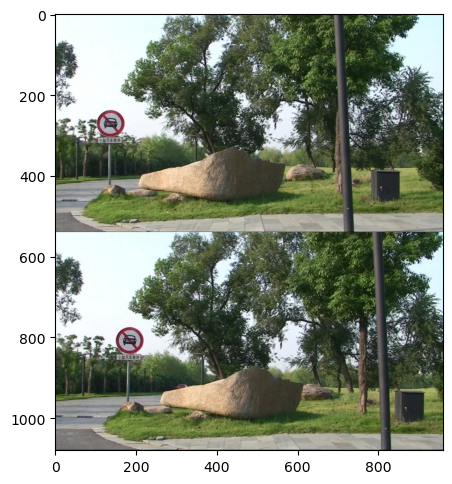

In [7]:
im1 = cv2.imread('depth_im3.jpg',cv2.IMREAD_COLOR)
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
im2 = cv2.imread('depth_im4.jpg',cv2.IMREAD_COLOR)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)

im = np.vstack((im1,im2))
#show the original figure
plt.figure( figsize=(5,10) )
plt.imshow(im)

In [8]:
dmax = desparity(im1,86/96)
print(dmax)

0.00682830810546875


In [9]:
depth = 50
unary = nodes(im1,im2,depth,dmax)

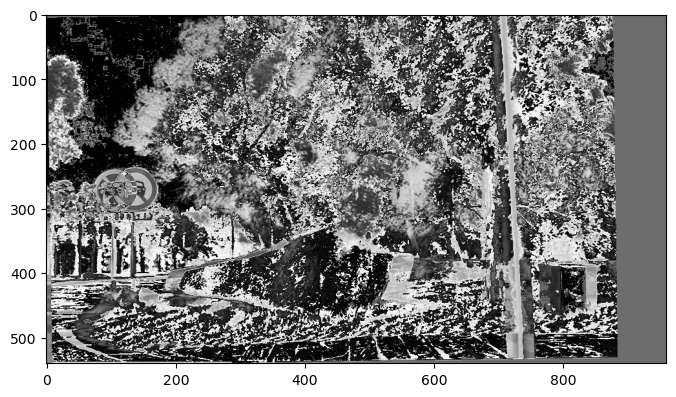

In [10]:
a = unary[:,:,49]
plt.figure( figsize=(8,8) )
plt.imshow(a,'gray')

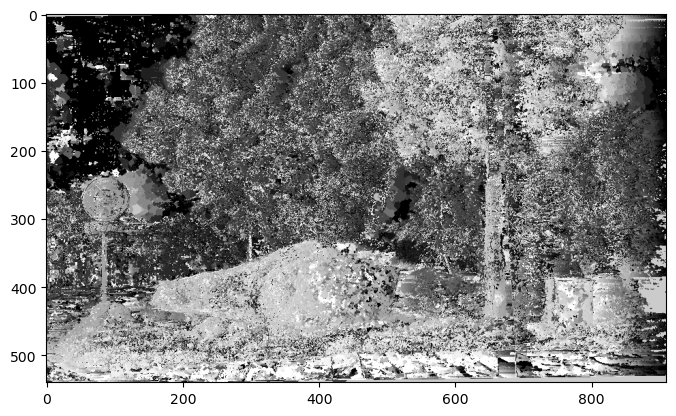

In [11]:
lmd = 0.01
labels = gcut(unary,depth,lmd)
plt.figure( figsize=(8,8) )
plt.imshow(labels,'gray')

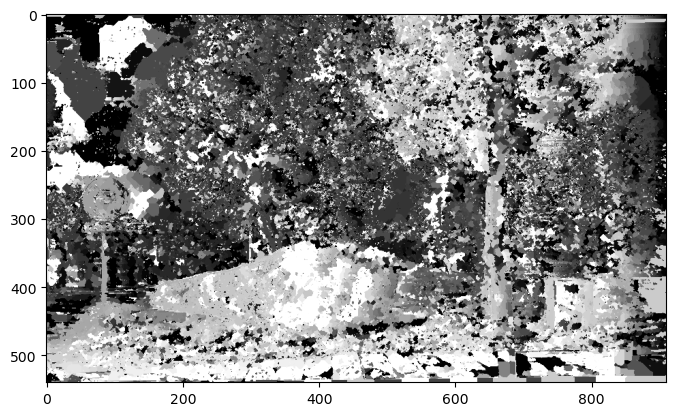

In [12]:
lmd = 0.1
labels = gcut(unary,depth,lmd)

plt.figure( figsize=(8,8) )
plt.imshow(labels,'gray')

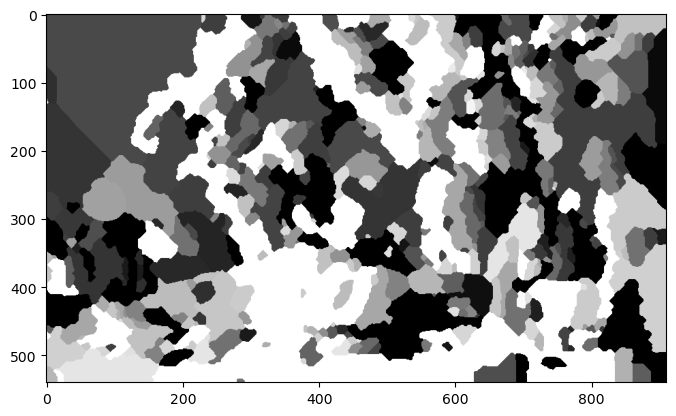

In [13]:
lmd = 1
labels = gcut(unary,depth,lmd)
plt.figure( figsize=(8,8) )
plt.imshow(labels,'gray')

In [18]:
depth = 50
unary = nodes(im1,im2,depth,0.0085)

lmd = 0.02
labels = gcut(unary,depth,lmd)

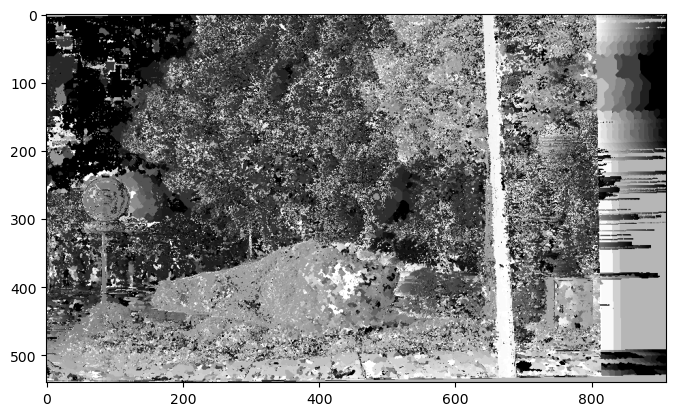

In [19]:
plt.figure( figsize=(8,8) )
plt.imshow(labels,'gray')

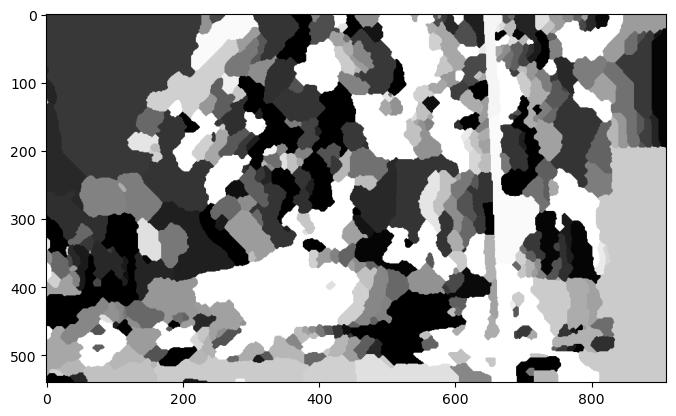

In [16]:
lmd = 1
labels = gcut(unary,depth,lmd)
plt.figure( figsize=(8,8) )
plt.imshow(labels,'gray')

# Change the smooth matrix

In [17]:
# graph cut
def gcut1(unary,depth,lmd):
    [row,col,c] = unary.shape
    fp = np.zeros([depth,depth])
    for i in range(depth):
        for j in range(depth):
                fp[i,j] = abs(i-j) ** 2 / 500
#     fp = 1 - np.eye(depth)
    labels = gco.cut_grid_graph_simple(unary, fp*lmd,connect = 8, n_iter=-1,algorithm = 'swap')
    labels = labels.reshape(row,col)
    labels = labels[:,depth:]
    return labels

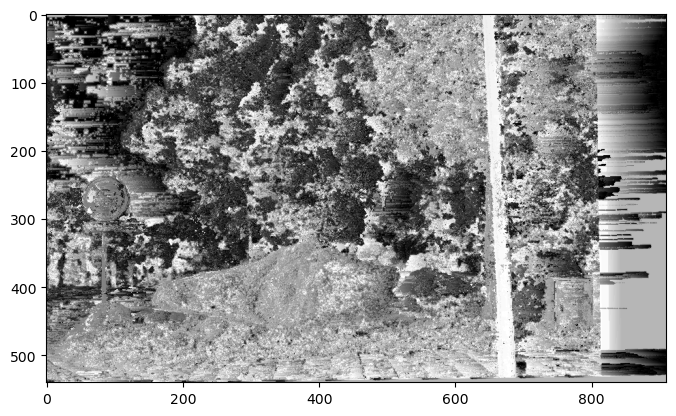

In [20]:
depth = 50
unary = nodes(im1,im2,depth,0.0085)

lmd = 0.02
labels = gcut1(unary,depth,lmd)

plt.figure( figsize=(8,8) )
plt.imshow(labels,'gray')

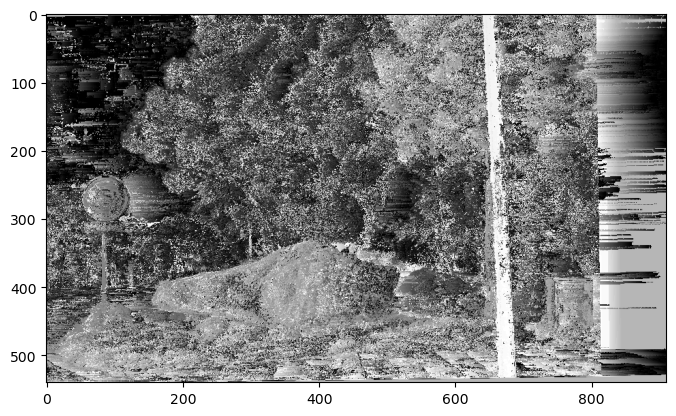

In [21]:
lmd = 0.001
labels = gcut1(unary,depth,lmd)

plt.figure( figsize=(8,8) )
plt.imshow(labels,'gray')

# This is the best performance depth map, it is still very noisy and need to denoise by change the smooth parameter. 